In [1]:
import matplotlib
# import matplotlib.cm as cm
# from matplotlib.colors import Normalize
# from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
# mark_inset)
# %matplotlib inline
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import numpy as np
# from numpy import isclose
from dolfin import *
# import matplotlib.pyplot as plt
from multiphenics import *

# import dolfin
# import multiphenics
# import matplotlib

# print(np.__version__) # 1.19.5
# print(matplotlib.__version__) # 3.0.3
# print(dolfin.__version__)# 2019.2.0.dev0

# Goal
?

In [2]:
# Some global parameters
tol = DOLFIN_EPS
degree = 2

sigma = 1
L = 1. # mesh size
dL = 0.1 # contact size

In [6]:
mesh_name = 'DBS'
mesh = Mesh(mesh_name+".xml")
subdomains = MeshFunction("size_t", mesh, mesh_name+"_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, mesh_name+"_facet_region.xml")
File("DBS_mesh.pvd") << boundaries

N=6 # number of contacts
cnt_id=33 # contacts id begin from this number

In [7]:
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
# dS = Measure("dS")(subdomain_data=boundaries)
n = FacetNormal(mesh)

In [77]:
V = FunctionSpace(mesh, "Lagrange", degree)
R = FunctionSpace(mesh, "R", 0) # global constant
W = BlockFunctionSpace([V]+[R]*(N))#, restrict=[None]+ contacts)

u_mix = BlockTrialFunction(W)
v_mix = BlockTestFunction(W)

# order: contact1, contact2, ...
u_spl = block_split(u_mix)
v_spl = block_split(v_mix)

z= 1e-9

# RHS
a_00 = inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
for i in range(N):
    a_00 += dot(u_spl[0],v_spl[0])/z*ds(i+cnt_id)
a_0n = [-dot(u_spl[0], v_spl[i+1])/z*ds(i+cnt_id) for i in range(N)]
a_n0 = [-dot(u_spl[i+1], v_spl[0])/z*ds(i+cnt_id) for i in range(N)]
a_nn = [+dot(u_spl[i+1], v_spl[i+1])/z*ds(i+cnt_id) for i in range(N)]


a = np.zeros((N+1,N+1), dtype=type(a_00))
np.fill_diagonal(a, [a_00]+a_nn)
a[0,1:] = a_0n
a[1:,0] = a_n0 
a = a.tolist()

# LHS
f= Expression("1-sin(x[0]/pi)", element=V.ufl_element())
I= [ Constant(0), Constant(0),Constant(0), Constant(0), Constant(0), Constant(0) ]
DL = [assemble(dot(n,n)*ds(i+cnt_id)) for i in range(N)] # actual contact length

b= [ f*v_spl[0]*dx ] + [ I[i]*v_spl[i+1]/DL[i]*ds(i+cnt_id) for i in range(N)]

# BC
bc0 = DirichletBC(W.sub(0), Constant(1) ,boundaries, 2) # left
bc1 = DirichletBC(W.sub(0), Constant(0), boundaries, 3) # right
bc2 = DirichletBC(W.sub(0), Constant(0), boundaries, 4) # bottom

bcs = BlockDirichletBC([[bc0, bc1]]+[[]]*N)

In [78]:
# SOLVE #
A = block_assemble(a)
B = block_assemble(b)

bcs.apply(A)
bcs.apply(B)

U = BlockFunction(W)
block_solve(A, U.block_vector(), B)

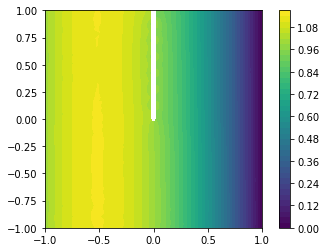

In [79]:
m =plot(U[0])
plt.colorbar(m)
plt.show()
File('sol_DBS.pvd') << U[0]

In [32]:


N

1

In [43]:
# sanity checks
# comp_currs = []
for i in range(cnt_id+N):
    I = assemble(-sigma*dot(grad(U[0]), n)*ds(i))
    l = assemble(dot(n, n)*ds(i))
    print('Current at border {} = {} \t length = {}'.format(i, I, l))

for i in range(cnt_id,cnt_id+N):
    I = assemble((U[0]-U[i+1-cnt_id])/z*ds(i))
    print('Current at contact {} = {}'.format(i, I))

Current at border 0 = 0.06200156125824218 	 length = 0.5000000000000001
Current at border 1 = 0.49394413544656857 	 length = 1.0
Current at border 2 = -3.889308801440184 	 length = 1.0
Current at border 3 = 4.2998387929951445 	 length = 1.0
Current at border 4 = 0.0689512688328337 	 length = 0.1
Current at border 5 = -0.008862724514743854 	 length = 0.09999999999999998
Current at border 6 = -0.009688886844226904 	 length = 0.09999999999999998
Current at border 7 = -0.010518358214418308 	 length = 0.09999999999999998
Current at border 8 = -0.010470810143234269 	 length = 0.09999999999999998
Current at contact 4 = -15.000000000000021
Current at contact 5 = -4.1633363770388065e-09
Current at contact 6 = -5.551114290458514e-10
Current at contact 7 = 4.440891834822658e-09
Current at contact 8 = -1.776356811644675e-08


In [13]:
U[1].vector().vec()[:]

array([6.40744613e-06])

In [14]:
# sanity checks
# comp_currs = []
for i in range(N):
    I = assemble(-sigma*dot(grad(U[0]), n)*ds(i+cnt_id))
    print('Current at contact {} = {}'.format(i, I))

Current at contact 0 = 0.07460534396761825


In [15]:
info(parameters,True)

In [16]:
for p in parameters:
    print(p,'\t\t',parameters[p])

allow_extrapolation 		 False
dof_ordering_library 		 SCOTCH
form_compiler 		 <dolfin.cpp.parameter.Parameters object at 0x7f52a01df9d0>
ghost_mode 		 none
graph_coloring_library 		 Boost
krylov_solver 		 <dolfin.cpp.parameter.Parameters object at 0x7f52a01df9d0>
linear_algebra_backend 		 PETSc
lu_solver 		 <dolfin.cpp.parameter.Parameters object at 0x7f52a01df9d0>
mesh_partitioner 		 SCOTCH
partitioning_approach 		 PARTITION
print_mpi_thread_support_level 		 False
refinement_algorithm 		 plaza
relative_line_width 		 0.025
reorder_cells_gps 		 False
reorder_dofs_serial 		 True
reorder_vertices_gps 		 False
std_out_all_processes 		 True
timer_prefix 		 
use_petsc_signal_handler 		 False
warn_on_xml_file_size 		 100


In [17]:
for sol in U:
    q = sol
    print(q.vector().vec().min(), q.vector().vec().max())

(0, 0.0) (5148, 1.0)
(0, 6.4074461282627465e-06) (0, 6.4074461282627465e-06)


In [18]:
q.vector().vec().min(), q.vector().vec().max()

((0, 6.4074461282627465e-06), (0, 6.4074461282627465e-06))

In [19]:
qq= U[0].vector().vec()#.shape()

In [20]:
qq.array_w

array([0.00000000e+00, 0.00000000e+00, 5.30832398e-06, ...,
       1.00000000e+00, 1.00000000e+00, 9.89959307e-01])

In [21]:
qq.assemble()

In [22]:
A00= assemble(a_00)
A00.array()

array([[ 2.66666767e+06,  1.66666667e-01, -6.66666500e+05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.66666667e-01,  2.00000000e+00, -1.77635684e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.66666500e+05, -1.77635684e-15,  5.33333533e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00, -6.66666667e-01, -6.66666667e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.66666667e-01,  2.66666667e+00,  6.43929354e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.66666667e-01,  6.43929354e-15,  2.66666667e+00]])

In [23]:
q= U.sub(1)

In [24]:
qv = q.vector()

In [25]:
qv.vec()[:]

array([6.40744613e-06])

In [26]:
len(qv)

1

In [27]:
W.split()

AttributeError: 'BlockFunctionSpace' object has no attribute 'split'

In [ ]:
mesh = UnitSquareMesh(20,20)
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)

left = Left(); left.mark(boundaries, 1)
right = Right(); right.mark(boundaries,2)
bottom = Bottom();  bottom.mark(boundaries, 3)
hole = Hole(); hole.mark(boundaries, 4)
File('boundaries.pvd') << boundaries

dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
dS = Measure("dS")(subdomain_data=boundaries)
n = FacetNormal(mesh)

for i in range(5):
    print(assemble(dot(n,n)*ds(i)))
    
10*0.2 + 16*sqrt(2)*0.2/4